In [311]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import keras.backend as K
import plotly.express as px
from sklearn.metrics import classification_report
from tensorflow.keras.applications import xception, inception_resnet_v2
from matplotlib import pyplot as plt
import cv2 as cv
import tensorflow.keras.preprocessing.image as Image
%matplotlib inline

In [2]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# Reading data
files = tf.io.gfile.glob(r"D:/Desktop/Practicum/Covid recognition/Data/COVID 19/*")
files.extend(tf.io.gfile.glob(r"D:/Desktop/Practicum/Covid recognition/Data/NORMAL/*"))
files.extend(tf.io.gfile.glob(r"D:/Desktop/Practicum/Covid recognition/Data/Viral Pneumonia/*"))

# obtaining split sets
train_files, test_files = train_test_split(files, test_size=0.1, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

# converting to tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)

TRAIN_SIZE = tf.data.experimental.cardinality(train_dataset).numpy()
VAL_SIZE = tf.data.experimental.cardinality(val_dataset).numpy()
TEST_SIZE = tf.data.experimental.cardinality(test_dataset).numpy()

In [4]:
'''
takes a file path as input
returns the target value for the given image
'''
def get_targets(file):
    split = tf.strings.split(file, os.path.sep)
    if split[-2] == 'COVID 19':
        return 0
    elif split[-2] == 'Viral Pneumonia':
        return 2
    else: return 1
    
'''
input: file path of image
returns a processed image along with the target
'''
def preprocess_img(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    
    return img, target

'''
input: image dataset
returns: shuffled, batched and prefetched set of images
return type: PrefetchDataset
'''
def preprocessing(dataset, buffer_size=650):
    dataset = dataset.shuffle(buffer_size=buffer_size).repeat()
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

def preprocess_img_xception(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = xception.preprocess_input(img)
    
    return img, target

def preprocess_img_inception(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = inception_resnet_v2.preprocess_input(img)
    
    return img, target

In [5]:
# preprocessing datasets
train_data = train_dataset.map(preprocess_img_inception)
val_data = val_dataset.map(preprocess_img_inception)
test_data = test_dataset.map(preprocess_img_inception)

# batching test set
test_set = test_data.batch(BATCH_SIZE)

train_set = preprocessing(train_data)
val_set = preprocessing(val_data)

In [6]:
# load the xception model
model = tf.keras.models.load_model(r"D:/desktop/Practicum/covid_model_inception_resnet.h5")

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization_5[0][0]      
______________________________________________________________________________________________

conv2d_174 (Conv2D)             (None, None, None, 2 129024      activation_172[0][0]             
__________________________________________________________________________________________________
batch_normalization_178 (BatchN (None, None, None, 2 672         conv2d_174[0][0]                 
__________________________________________________________________________________________________
activation_173 (Activation)     (None, None, None, 2 0           batch_normalization_178[0][0]    
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, None, None, 1 399360      block8_2_ac[0][0]                
__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, None, None, 2 172032      activation_173[0][0]             
__________________________________________________________________________________________________
batch_norm

In [250]:
layer_names = [layer.name for layer in model.layers]
# layer_names

In [251]:
layer_names = [i for i in layer_names if i.startswith('conv2d')]
layer_names = [layer_names[i] for i in range(0,len(layer_names),22)] + ['conv_7b']
layer_names

['conv2d_1',
 'conv2d_21',
 'conv2d_47',
 'conv2d_70',
 'conv2d_90',
 'conv2d_109',
 'conv2d_134',
 'conv2d_153',
 'conv2d_178',
 'conv2d_199',
 'conv_7b']

In [16]:
model.evaluate(test_set)

13/13 [==============================] - 15s 1s/step - loss: 0.0704 - accuracy: 0.9820


[0.07036125252954242, 0.9820051]

In [17]:
# unbatch test data
test_x = test_set.take(5000).map(lambda X,y: X)
test_y = test_set.take(5000).map(lambda X,y: y)
test_y = tf.data.Dataset.unbatch(test_y)

In [424]:
sample_test_batch = test_x.take(1)
sample_images = tf.data.Dataset.unbatch(sample_test_batch)
sample_images = sample_images.take(30)
temp = [i.numpy() for i in sample_images.take(30)]
# change here
sample_image = temp[8]
sample_image.shape = (1,sample_image.shape[0], sample_image.shape[1], sample_image.shape[2])
sample_label = np.array([2])
sample_label.shape = (1,)
ds = tf.data.Dataset.from_tensor_slices((sample_image, sample_label))
ds = ds.batch(BATCH_SIZE)

In [425]:
pred = model.predict(ds)

In [426]:
pred[0]

array([3.0932448e-08, 1.0000000e+00, 1.5438808e-08], dtype=float32)

In [427]:
np.argmax(pred[0])

1

In [428]:
# obtaining ground truth targets
y_true = []
for i in test_y.take(30):
    y_true.append(i.numpy())

In [415]:
y_true

[1,
 2,
 2,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 2,
 2,
 0]

In [429]:
pred_vector_out = model.output[:, 2]
heatmap = []

for layer in layer_names[-1:]:
    curr_layer = model.get_layer(layer)
    gradients = K.gradients(pred_vector_out, curr_layer.output)[0]
    pooled_gradients = K.mean(gradients, axis=(0,1,2))
    iterate = K.function([model.input], [pooled_gradients, curr_layer.output[0]])
    pooled_gradients_val, layer_out_value = iterate([sample_image])
    
    for i in range(model.get_layer(layer).output_shape[-1]):
        layer_out_value[:,:,i] *= pooled_gradients_val[i]
        
        
    heatmap.append(np.mean(layer_out_value, axis=-1))

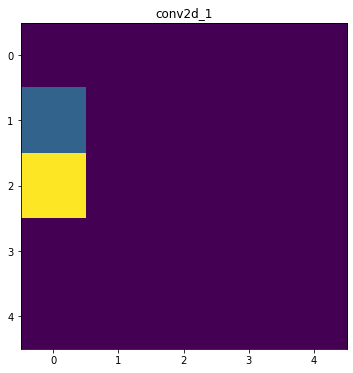

In [430]:
for i in range(len(layer_names[-1:])):
    img_heatmap = np.maximum(heatmap[i], 0)
    img_heatmap /= np.max(img_heatmap)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_heatmap)
    plt.title(layer_names[i])
    plt.show()

#### Obtaining the raw (unprocessed by deep model's preprocessing func) test images

In [431]:
test_data_2 = test_dataset.map(preprocess_img)

In [432]:
arr = []
for i,j in test_data_2.take(30):
    arr.append(i)

In [433]:
# change here
test_raw_img = arr[8]

In [434]:
test_raw_img = Image.img_to_array(test_raw_img)
# normal_img_cv = np.uint8(normal_img)

In [435]:
for i, m in enumerate(heatmap):
    img_heatmap = np.maximum(m,0)
    img_heatmap /= np.max(img_heatmap)
    
    img_hm = cv.resize(img_heatmap, (test_raw_img.shape[0], test_raw_img.shape[1]))
    
    img_hm = np.uint8(255 * img_hm)
    
    img_hm = cv.applyColorMap(img_hm, cv.COLORMAP_JET)
#     img_hm = img_hm * 0.7
#     superimposed_img = img_hm + test_raw_img
#     superimposed_img = np.array(superimposed_img)
#     cv.imwrite(r'D:\Desktop\Practicum\Covid recognition\output\covid_{}.jpg'.format(layer_names[i]), img_hm)
    cv.imwrite(r'D:\Desktop\Practicum\Covid recognition\output\covid_{}.jpg'.format(layer_names[-1]), img_hm)

Text(0.5, 1.0, 'conv_7b')

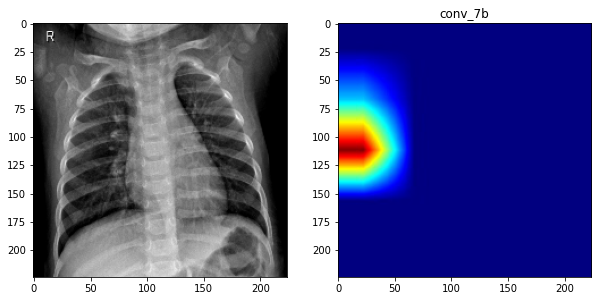

In [436]:
layer_name = 'conv_7b'
img = Image.img_to_array(
    Image.load_img(r'D:\Desktop\Practicum\Covid recognition\output\covid_{}.jpg'.format(layer_name))) / 255.
f, axarr = plt.subplots(1,2, figsize=(10,6))
axarr[0].imshow(test_raw_img)
axarr[1].imshow(img)
plt.title(layer_name)